In [255]:
import os
import sys
import pickle
import warnings 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy import stats

from utils import *
from AnalyseDefects import AnalyseDefects

plt.style.use('sg_article')

#### TODO:
0) Lav noget cleanup af funktioner (indbyg mean i extract og væk med std for cluster size etc)
01) Måske er et hist af Nfraction og clustersize med sammenligning og kolmogrov et renere resultat
1) Gør stat.-analysen præsenterbar
2) Indsæt .225 when done
3) Overvej Nmin. Er 3 OK?
4) Prøv at smide noise ind på N i Poisson og se forskel(eller initaliser præcist ud fra N i hvert frame)
5) Efter proof of concept, byg det ind i infrastrukturen og lav analysen på tværs af L

In [222]:
def gen_clustering_metadata(path,):

    Nexp_list = []
    act_list = []
    act_dir_list = []
 
    for i, dir in enumerate(os.listdir(path)):
        if dir.startswith('analysis'):
            act_list.append(float(dir.split('_')[-1]))
            act_dir_list.append(os.path.join(path, dir))
    for i, file in enumerate(os.listdir(os.path.join(path, os.listdir(path)[0]))):
        if file.startswith('zeta'):
            Nexp_list.append(int(file.split('_')[-1]))

    return Nexp_list, act_list, act_dir_list


def do_poisson_clustering(Nlist, L, Ntrial, Ncmin = 2, method_kwargs = dict(n_clusters=None, linkage = 'single', distance_threshold=33)):
    """
    Perform the poisson clustering for a given set of parameters
    """

    cluster_arr = np.nan * np.zeros([4, len(Nlist), Ntrial])

    for i, N in enumerate(Nlist):

        p_arr = np.random.rand(N, 2, Ntrial) * L   
        cst = AgglomerativeClustering(**method_kwargs)

        for j in range(Ntrial):

            # Get defect array for frame
            defect_positions = p_arr[:, :, j]

            labels = cst.fit_predict(defect_positions)

            unique, counts = np.unique(labels, return_counts=True)

            # Only count clusters with more than Ncmin defects
            mask = (counts >= Ncmin)

            counts_above_min = counts[mask]

            # Find the sizes of the clusters and the number of clusters of each size
            cluster_sizes, _ = np.unique(counts_above_min, return_counts=True)

            # store the total number of defects
            cluster_arr[0, i, j] = N

            # store the number of clustered defects
            cluster_arr[1, i, j] = counts_above_min.sum()

            # store the number of clusters
            cluster_arr[2, i, j] = len(counts_above_min)
    
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)

                # store the average cluster size
                cluster_arr[3, i, j] = np.mean(counts_above_min)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        cl_mean = np.nanmean(cluster_arr, axis = -1)
        cl_std = np.nanstd(cluster_arr, axis = -1)
        cl_std /= np.sqrt(len(Nlist) * Ntrial)

    return cluster_arr, cl_mean, cl_std


def extract_clustering_results(Nframes, act_list, act_dir_list, Nexp, Ncmin=2, save = True,):
    """
    Analyse the defects for all the input folders
    """
    for N in range(1):

        # create arrays to store the clustering data
        cluster_arr = np.nan * np.zeros([Nframes, 5, len(act_list), Nexp])
        
        # print('Analysing clustering data for input folder {}'.format(self.input_paths[N]))
        for i, (act, act_dir) in enumerate(zip(act_list, act_dir_list)):

            exp_list = []
            exp_dir_list = []

            for file in os.listdir(act_dir):
                exp_count = file.split('_')[-1]
                exp_list.append(int(exp_count))
                exp_dir_list.append(os.path.join(act_dir, file))

            # sort the activity list and the activity directory list
            exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

            for j, (exp, exp_dir) in enumerate(zip(exp_list, exp_dir_list)):

                with open(os.path.join(exp_dir, 'labels_rm33.pkl'), 'rb') as f:
                        labels = pickle.load(f)
                nan_counter = 0
                for k, frame in enumerate(labels[:Nframes]):
                        
                        if frame is None:
                            nan_counter += 1
                            continue
                             
                        # store the number of defects 
                        cluster_arr[k, 0, i, j] = len(frame)

                        unique, counts = np.unique(frame, return_counts=True)

                        # Only count clusters with more than Ncmin defects
                        mask = (counts >= Ncmin)
                        counts_above_min = counts[mask]

                        # Find the sizes of the clusters and the number of clusters of each size
                        cluster_sizes, cluster_counts = np.unique(counts_above_min, return_counts=True)

                        # store the number of clustered defects
                        cluster_arr[k, 1, i, j] = counts_above_min.sum()
                        # store the number of clusters
                        cluster_arr[k, 2, i, j] = len(counts_above_min)
                
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore", category=RuntimeWarning)
                            # store the average cluster size
                            cluster_arr[k, 3, i, j] = np.nanmean(counts_above_min)
                            # store the standard deviation of the cluster sizes
                            cluster_arr[k, 4, i, j] = np.nanstd(counts_above_min)
        if save:
            pass
    return cluster_arr

In [74]:
base_path = 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na512'
d_cluster_l = dict(path = base_path + 'l_cl', \
              suffix = "l_cl", priority = 1, LX = 512, Nframes = 400)
d_cluster_vl = dict(path = base_path + 'vl_cl', \
              suffix = "vl_cl", priority = 1, LX = 512, Nframes = 1500)
d_list = [d_cluster_l, d_cluster_vl]

In [75]:
Nexp_l, act_l, act_dir_l = gen_clustering_metadata(d_cluster_l['path'])
Nframes_l = 400
Nexp_vl, act_vl, act_dir_vl = gen_clustering_metadata(d_cluster_vl['path'])
Nframes_vl = 1500

In [266]:
Ncmin = 3
cl_arr_l = extract_clustering_results(Nframes_l, act_l, act_dir_l, len(Nexp_l), Ncmin=Ncmin, save=False)
cl_arr_vl = extract_clustering_results(Nframes_vl, act_vl, act_dir_vl, len(Nexp_vl), Ncmin=Ncmin, save=False)

In [267]:
cl_mean_l = np.nanmean(cl_arr_l, axis=(0,-1))
cl_std_l = np.nanstd(cl_arr_l, axis=(0,-1))
cl_std_l = cl_std_l  / np.sqrt(Nframes_l * len(Nexp_l))

# replace av cluster size std in cl_mean with std of mean from cl_std
cl_mean_l[-1, :] = cl_std_l[-2,:] 

cl_mean_vl = np.nanmean(cl_arr_vl, axis=(0,-1))
cl_std_vl = np.nanstd(cl_arr_vl, axis=(0,-1))
cl_std_vl = cl_std_vl  / np.sqrt(Nframes_vl * len(Nexp_vl))

# replace av cluster size std in cl_mean with std of mean from cl_std
cl_mean_vl[-1, :] = cl_std_vl[-2,:] 

cl_mean = np.concatenate([cl_mean_l[:,0][:, None], cl_mean_vl, cl_mean_l[:,1:]], axis=1)
cl_std = np.concatenate([cl_std_l[:,0][:, None], cl_std_vl, cl_std_l[:,1:]], axis=1)

act_list = np.unique(np.concatenate([act_l, act_vl, act_l[1:]]))

In [269]:
N_list = cl_mean[0,:].astype('int') #- cl_std[0,:].astype('int') 
Rmax = 33
method_kwargs = dict(n_clusters=None, linkage = 'single', distance_threshold=Rmax)

L = 512
Rmax = 33
Ntrial = 4000

_, cl_mean_uni, cl_std_uni = do_poisson_clustering(N_list, L, Ntrial, Ncmin = Ncmin, method_kwargs = method_kwargs)

In [270]:
# For ndef 
cl_mean_uni[:,-5], cl_std_uni[:,-5] 

(array([148.        , 101.5725    ,  18.366     ,   5.61269499]),
 array([0.        , 0.03579241, 0.01195878, 0.00346225]))

In [271]:
cl_mean[:,-5]

array([1.48554867e+02, 1.06152333e+02, 1.48097333e+01, 7.10983534e+00,
       1.74602372e-02])

In [272]:
dif = cl_mean[:-1,:] - cl_mean_uni
dif_std = np.sqrt(cl_std[:-1,:]**2 + cl_std_uni**2)

zstat = dif[:,:] / dif_std[:,:] 

for i, act in enumerate(act_list):
    print('Activity: {}'.format(act))
   # print('Z-statistic: {}'.format(zstat[1,i]))
    print('P-value (Nclustered the same): {}'.format(stats.t.sf(np.abs(zstat[1,i]), df = 2 - 1)))
    print('P-value (cluster size the same): {}'.format(stats.t.sf(np.abs(zstat[-1,i]), df = 2 - 1)))
#p_val = stats.t.sf(np.abs(zstat), df = 2 - 1)

Activity: 0.019
P-value (Nclustered the same): 0.19776964815463274
P-value (cluster size the same): nan
Activity: 0.0195
P-value (Nclustered the same): 0.023255527914453167
P-value (cluster size the same): 0.009368083610459356
Activity: 0.02
P-value (Nclustered the same): 0.013137348650566294
P-value (cluster size the same): 0.006135582775666718
Activity: 0.0205
P-value (Nclustered the same): 0.01418796454820661
P-value (cluster size the same): 0.0086304451630325
Activity: 0.021
P-value (Nclustered the same): 0.009843185966434156
P-value (cluster size the same): 0.007521783915699768
Activity: 0.0215
P-value (Nclustered the same): 0.005731748617626426
P-value (cluster size the same): 0.005151821218668848
Activity: 0.022
P-value (Nclustered the same): 0.02419727514538881
P-value (cluster size the same): 0.0037843561275882325
Activity: 0.0225
P-value (Nclustered the same): 0.012867541269588554
P-value (cluster size the same): 0.00535671322765218
Activity: 0.023
P-value (Nclustered the sam

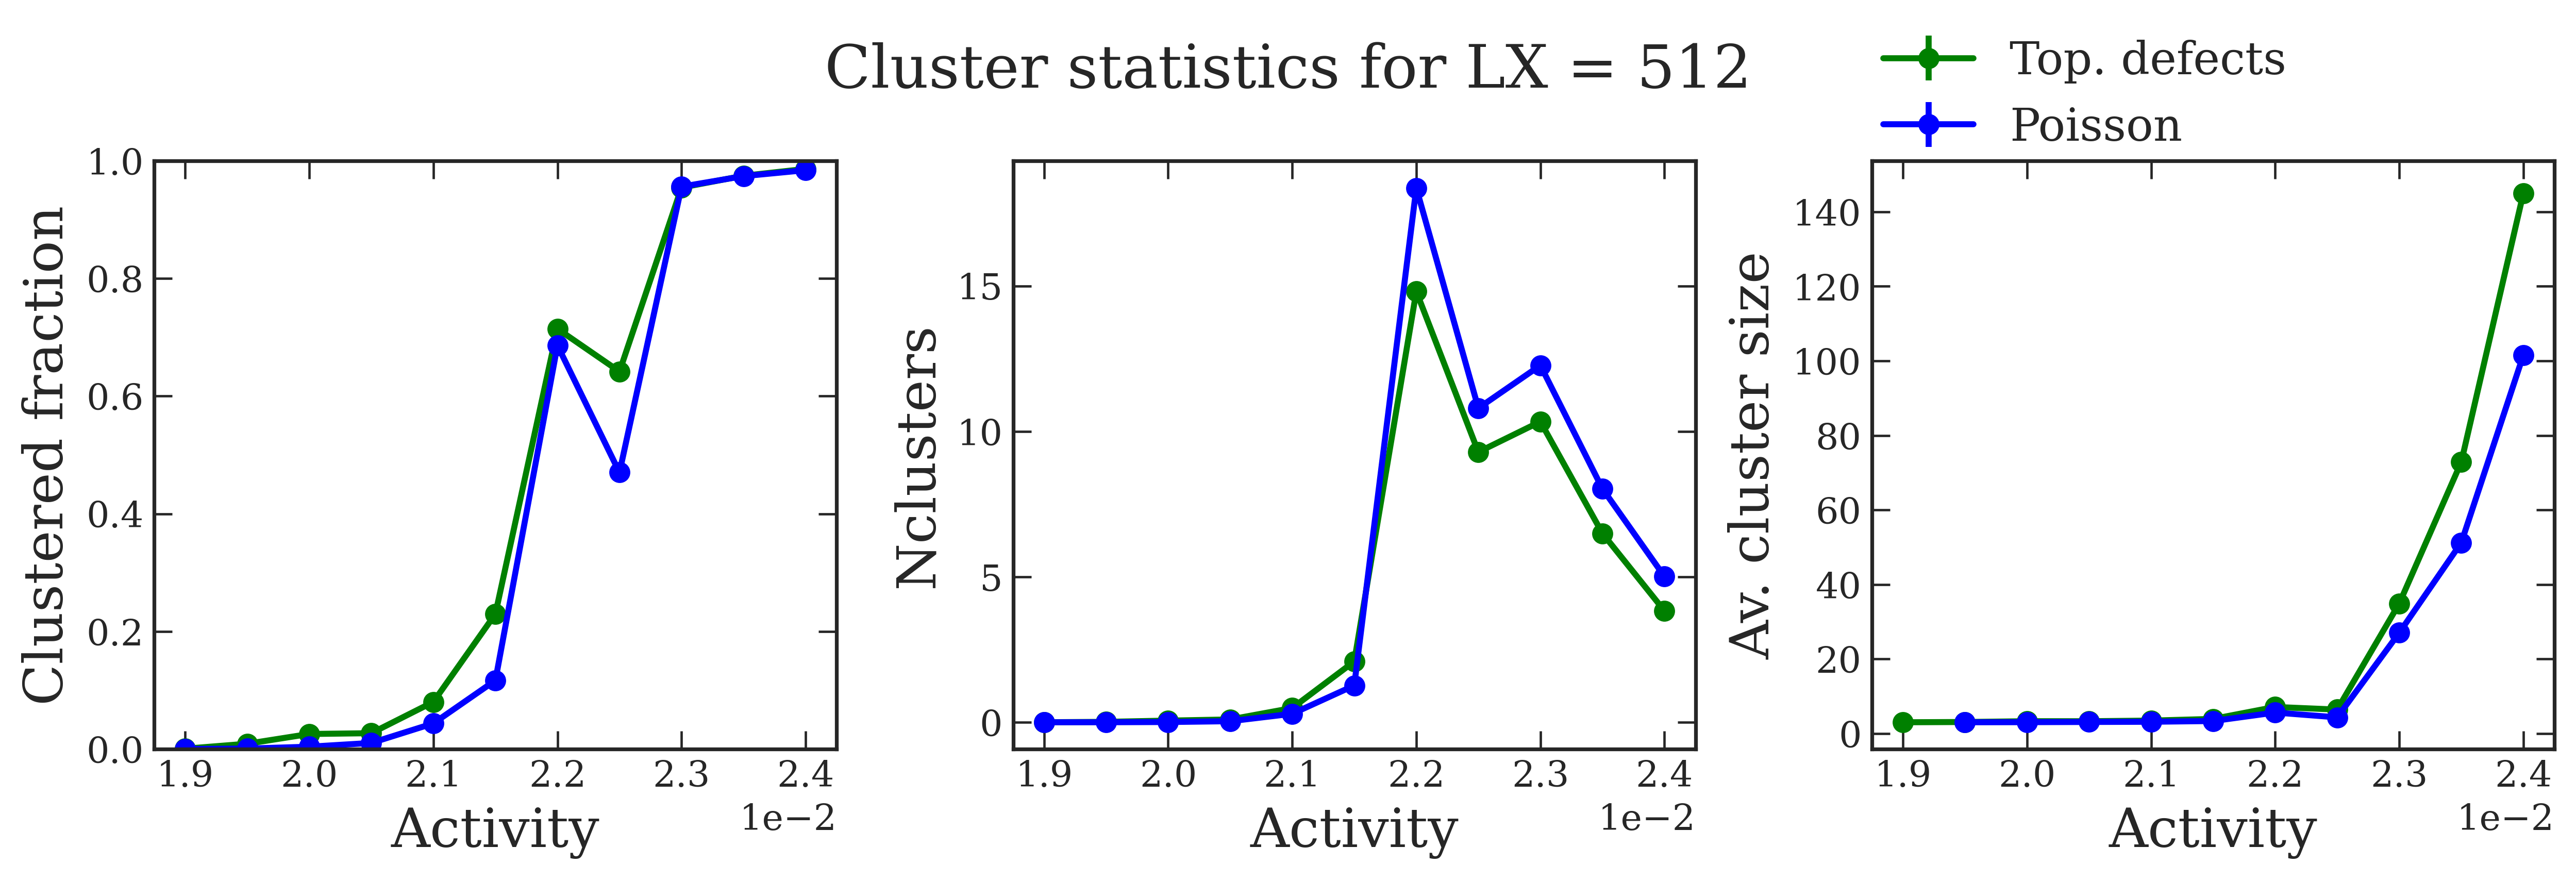

In [273]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4)) 
Y = [cl_mean[1,:] / cl_mean[0, :], cl_mean[2,:], cl_mean[3,:]]
dY = [cl_std[1,:] / cl_mean[0, :], cl_std[2,:], cl_std[3,:]]

Y_uni = [cl_mean_uni[1,:] / cl_mean_uni[0, :], cl_mean_uni[2,:], cl_mean_uni[3,:]]
dY_uni = [cl_std_uni[1,:] / cl_mean_uni[0, :], cl_std_uni[2,:], cl_std_uni[3,:]]

for i in range(3):
    if i == 0:
        ax[i].set_ylim(0, 1)    
        kwargs_dict = dict(label = 'Top. defects')
        kwargs_dict_uni = dict(label = 'Poisson')
    else:
        kwargs_dict = dict()
        kwargs_dict_uni = dict()
    ax[i].errorbar(act_list, Y[i], yerr=dY[i], fmt='-o', color = 'green', **kwargs_dict)
    ax[i].errorbar(act_list, Y_uni[i], yerr=dY_uni[i], fmt='-o', color = 'blue', **kwargs_dict_uni)
    ax[i].set_xlabel(f'Activity')
    ax[i].set_ylabel(['Clustered fraction','Nclusters', 'Av. cluster size'][i])
    #ax[i].legend()
fig.suptitle(f'Cluster statistics for LX = 512');
fig.legend(loc = 'upper right', bbox_to_anchor=(0.9, 1.03))

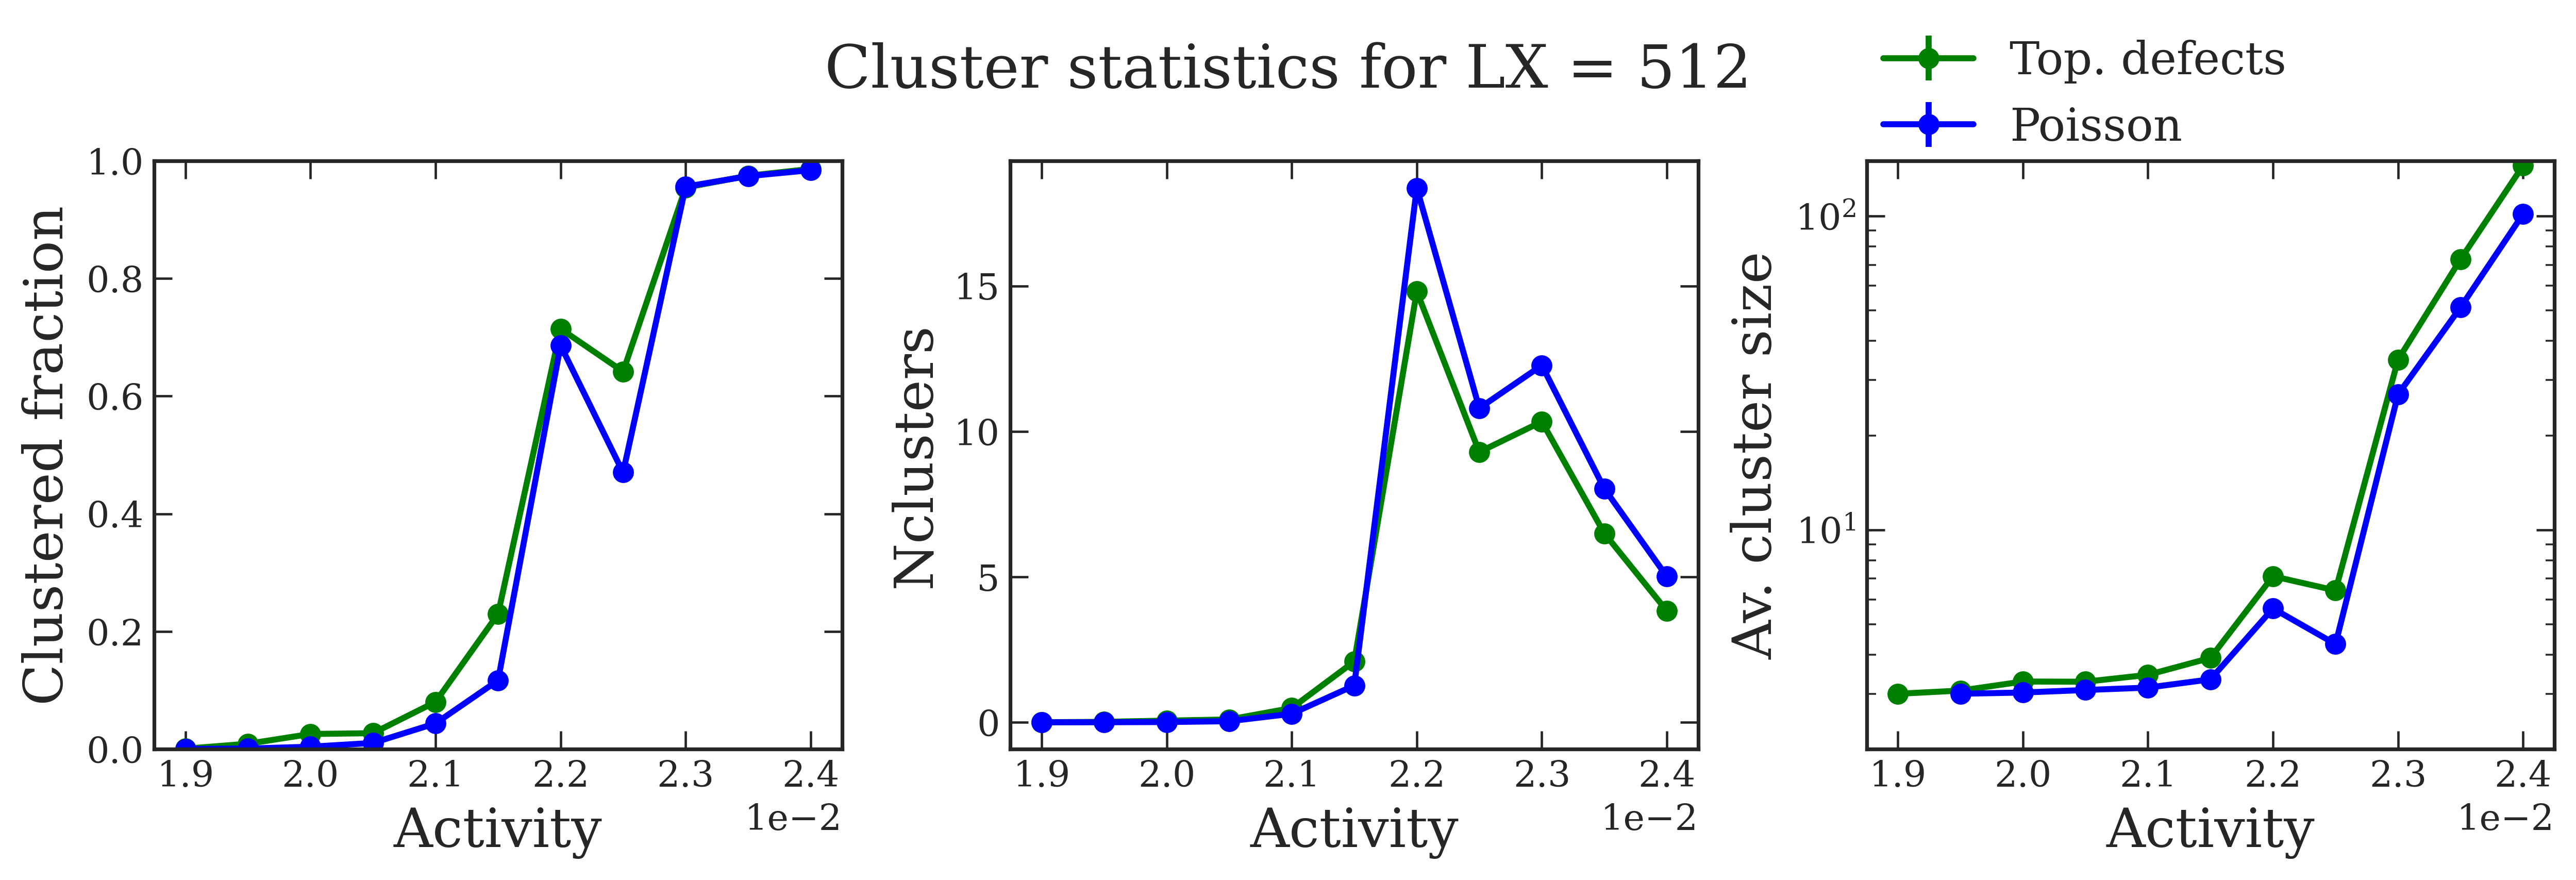

In [274]:
ax[-1].set_ylim(2, 150)  
ax[-1].set_yscale('log')    
fig